In [58]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
import scipy.stats as stats
from scipy.stats import probplot
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split

Cleaned data further, so it is a more consistent value than

In [59]:
df = pd.read_csv('stock_data.csv')
# changing dates timestamp so it's easier to graph/predict in the future, and getting just the needed data for our model
data = df[['Date', 'Close', 'Sector']].copy()
data.Date = pd.to_datetime(df.Date, utc=True).dt.tz_convert(None).astype('int64') // 10**9
data = data[['Date', 'Close']].groupby('Date').mean()
data.reset_index(inplace=True, drop=False)
data

,Date,Close
0,1583125200,114.272548
1,1583211600,111.996398
2,1583298000,116.865143
3,1583384400,112.986330
4,1583470800,110.983394
...,...,...
1252,1740373200,218.919193
1253,1740459600,220.214252
1254,1740546000,220.129482
1255,1740632400,218.104620


In [60]:
def add_bias_column(X):
    """
    Args:
        X (array): can be either 1-d or 2-d
    
    Returns:
        Xnew (array): the same array, but 2-d with a column of 1's in the first spot
    """
    
    # If the array is 1-d
    if len(X.shape) == 1:
        Xnew = np.column_stack([np.ones(X.shape[0]), X])
    
    # If the array is 2-d
    elif len(X.shape) == 2:
        bias_col = np.ones((X.shape[0], 1))
        Xnew = np.hstack([bias_col, X])
        
    else:
        raise ValueError("Input array must be either 1-d or 2-d")

    return Xnew

In [61]:
def line_of_best_fit(X, y):
    """
    Args: 
         X (array): can be either 1-d or 2-d
         y (array): 1-d, values to predict
    Returns:
        a np.array, containing M and b values for line formula Y = Mx + b
    """
    biased = add_bias_column(X)
    inv = np.linalg.inv(np.matmul(biased.T, biased))
    return np.matmul(np.matmul(inv, biased.T),y)

In [62]:
def regression(x, best_fit):
    if len(x.shape) == 1:
        return x*best_fit[1] + best_fit[0]
    return np.sum(x*best_fit[1:], axis =1 ) + best_fit[0]

In [63]:
def evaluate_regression(X, y, model_name="Model"):
    """
    Evaluate a regression model and generate diagnostic plots for assumptions.

    Args:
        X (array): 1-d or 2-d array of x-values (features).
        y (array): 1-d array of actual y-values.
        model_name (str): Name of the model for titles.

    Returns:
        None: Prints MSE and R2, displays diagnostic plots.
    """
    print('Plots for ', model_name, '\n\n')
    #create train test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.733)

    best_fit = line_of_best_fit(X_train, y_train)

    y_pred = regression(X_test, best_fit)

    # Calculate residuals
    residuals = y_test - y_pred

    #plot the data and regression line
    plt.figure(figsize=(6, 4))
    plt.title('Average Stock Price Over Time')
    if len(X_test.shape) == 1:
        plt.scatter(X_test, y_test, alpha=.7)
        plt.plot(X_test, y_pred, color='orange')
    else:
        plt.scatter(X_test.T[0], y_test)
        plt.scatter(X_test.T[0], y_pred, color='orange', marker='_', s=8)

    # Calculate and print MSE and R2
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    print(f"{model_name} - Mean Squared Error: {mse:.4f}")
    print(f"{model_name} - R2: {r2:.4f}")

    # Diagnostic Plots
    plt.figure(figsize=(16, 12))

    # 1. Constant Variance
    plt.subplot(2, 2, 1)
    plt.scatter(y_pred, residuals, alpha=0.5)
    plt.axhline(0, color='red', linestyle='--')
    plt.xlabel('Fitted Values')
    plt.ylabel('Residuals')
    plt.title('Residuals vs Fitted (Constant Variance)')

    # 2. Residuals vs index/order (Independence)
    index = range(len(y_test))
    plt.subplot(2, 2, 2)
    plt.scatter(index, residuals, alpha=0.5)  # Use first column if multi-feature
    plt.axhline(0, color='red', linestyle='--')
    plt.xlabel('Time (or X)')
    plt.ylabel('Residuals')
    plt.title('Residuals vs Time (Independence)')

    # 3. Q-Q Plot (Normality)
    plt.subplot(2, 2, 3)
    probplot(residuals, dist="norm", plot=plt)
    plt.title('Q-Q Plot (Normality')

    # 4. Histogram of Residuals (Normality)
    plt.subplot(2, 2, 4)
    sns.histplot(residuals, kde=True, bins=30, color='green', alpha=0.6)
    plt.xlabel('Residuals')
    plt.title('Histogram of Residuals')


    plt.suptitle(f"{model_name} Diagnostic Plots", fontsize=16)
    plt.tight_layout()
    plt.show()
    print('\n'*5)

Plots for  Simple Linear Regression 


Simple Linear Regression - Mean Squared Error: 206.3460
Simple Linear Regression - R2: 0.8011


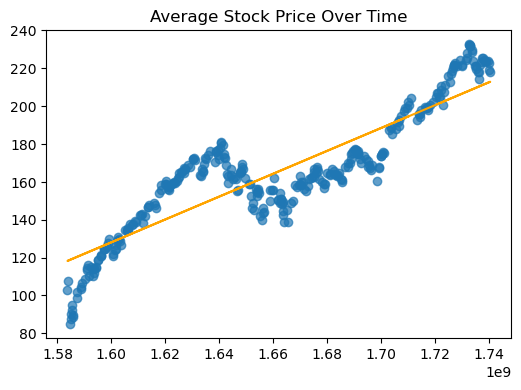

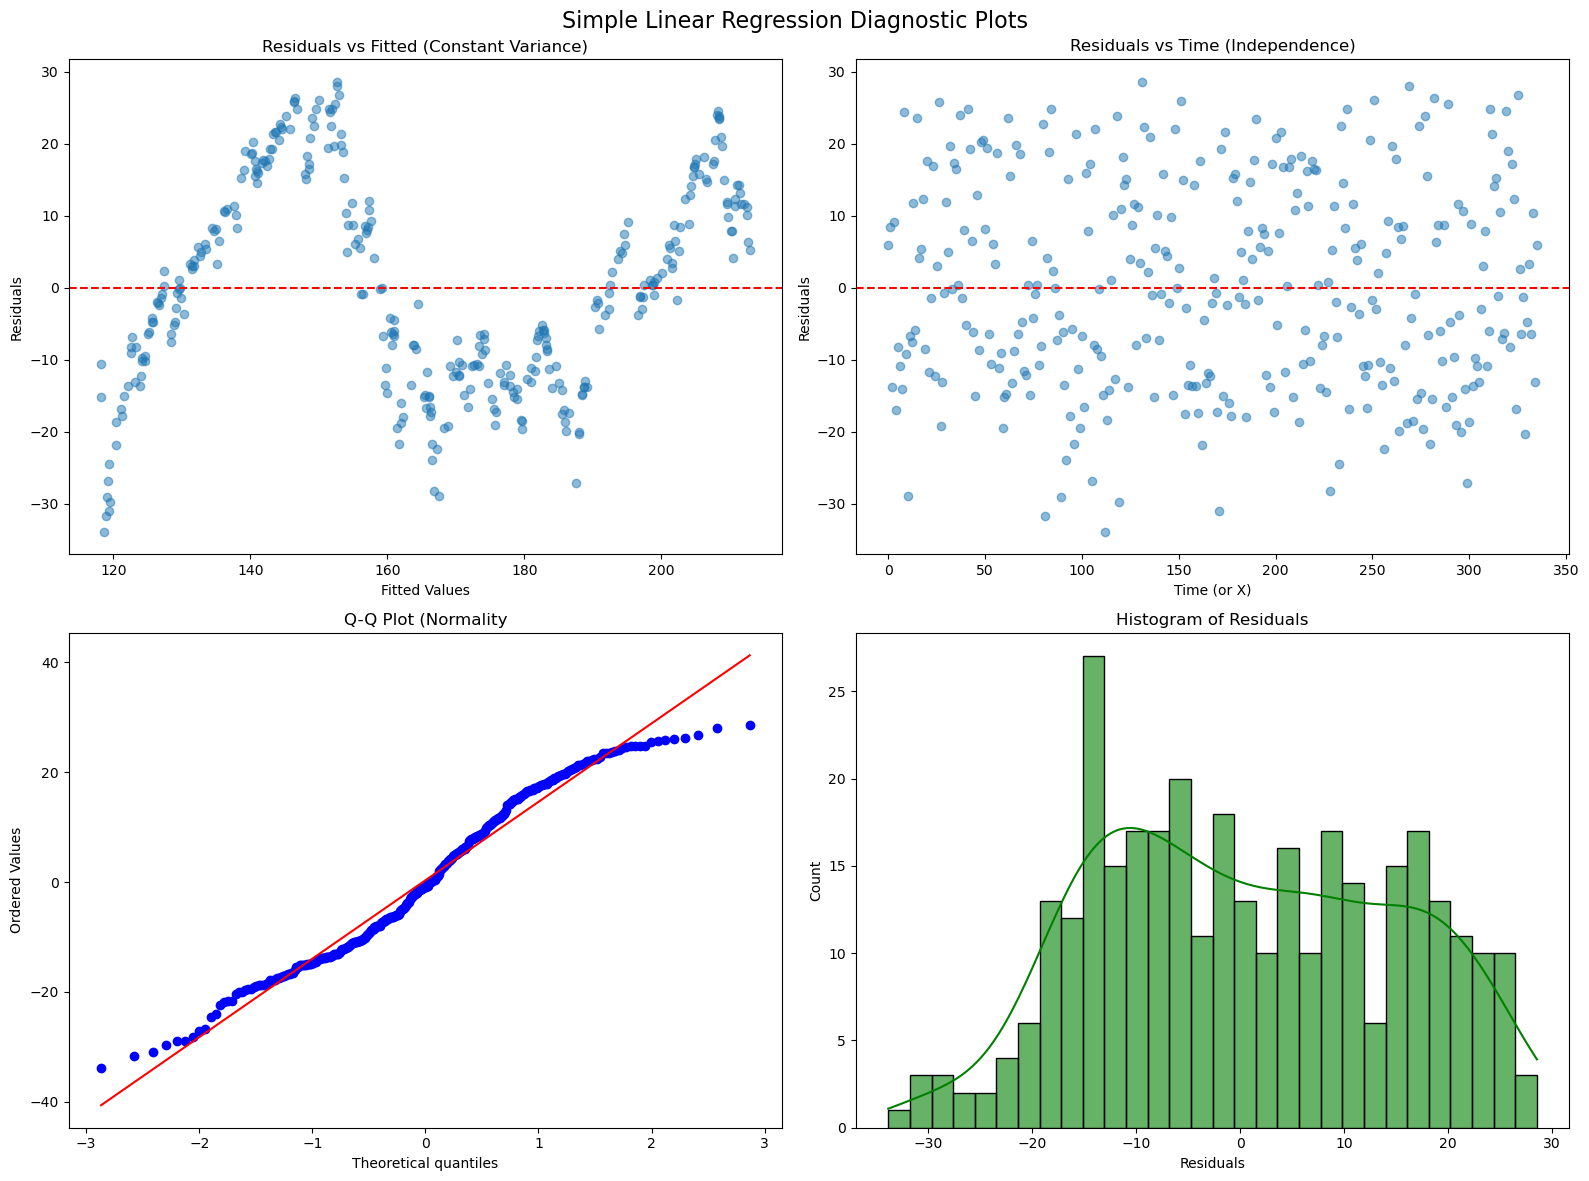







Plots for  Polynomial Regression 


Polynomial Regression - Mean Squared Error: 84.7883
Polynomial Regression - R2: 0.9070


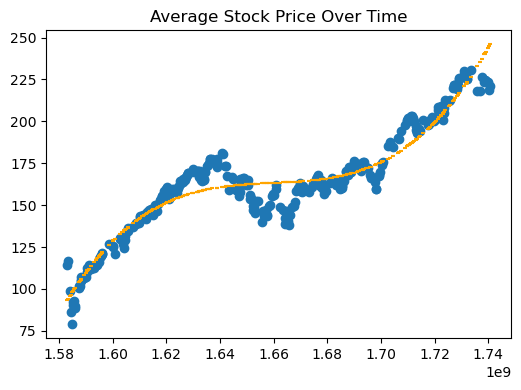

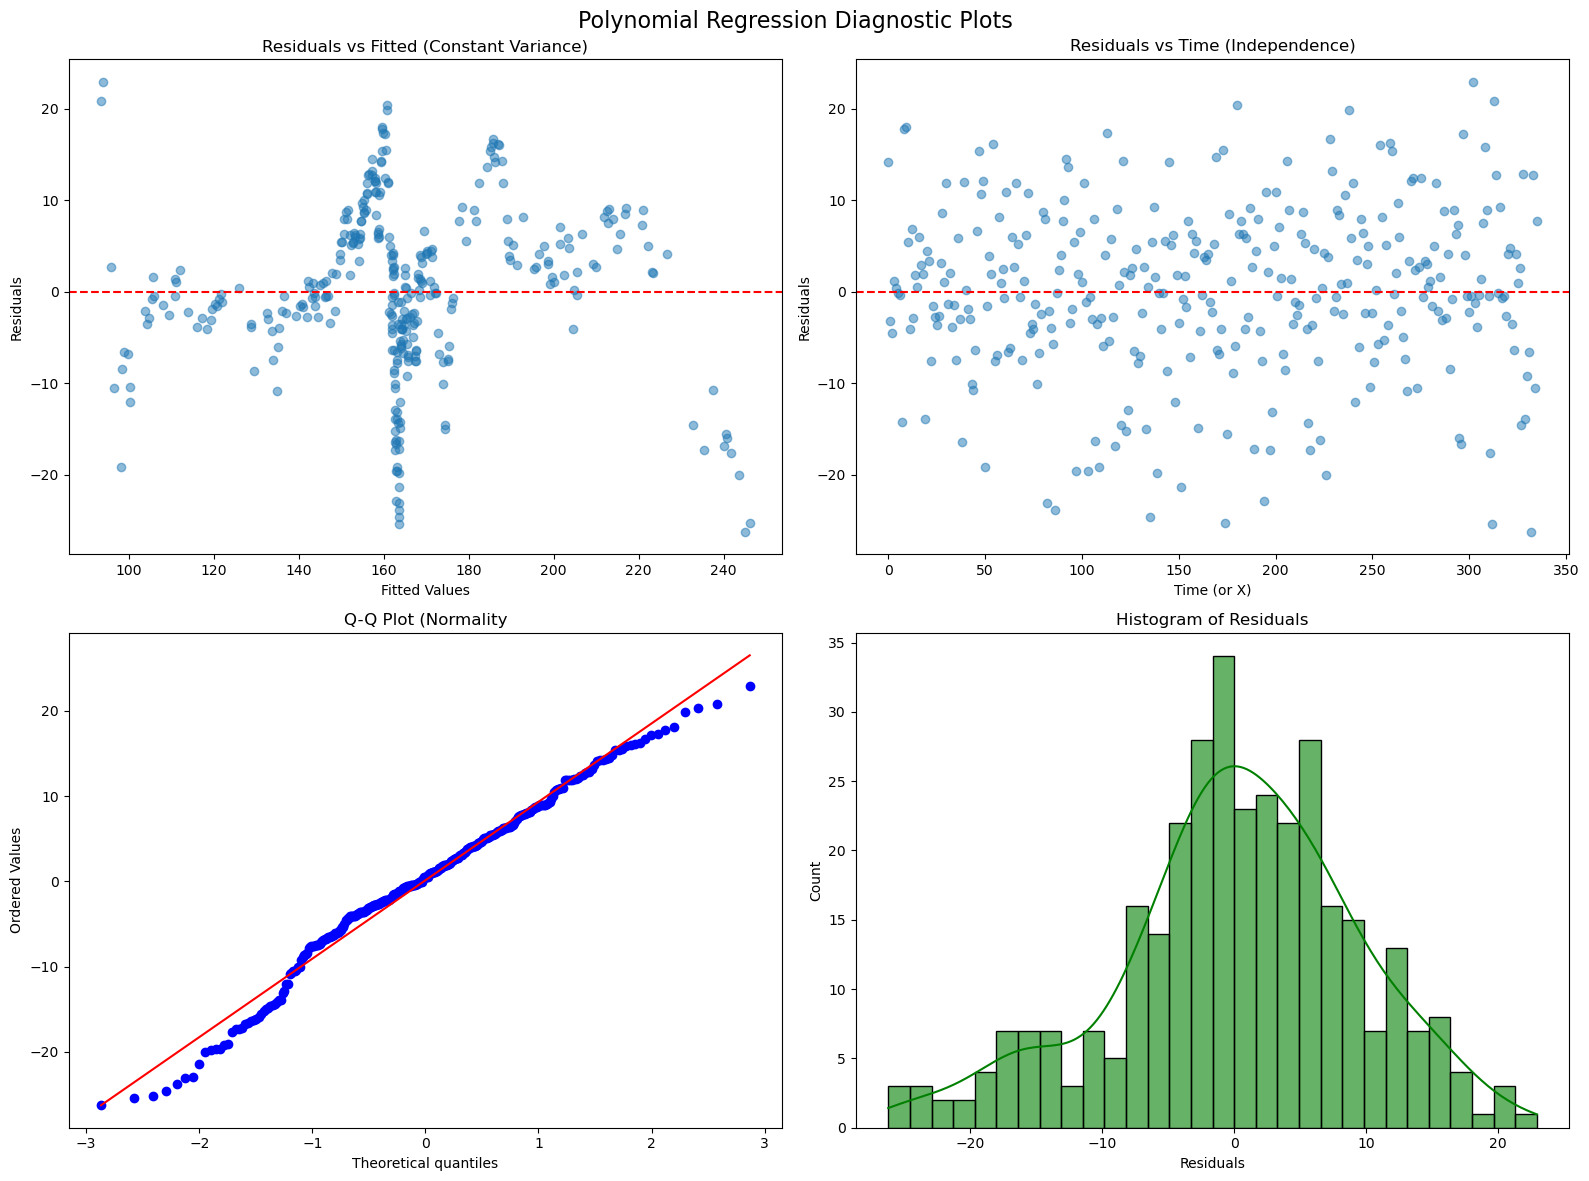

In [64]:
def main():
    poly = PolynomialFeatures(degree=3)
    X_poly = np.delete(poly.fit_transform(data.Date.to_numpy().reshape(-1,1)), 0, axis = 1)
    evaluate_regression(data.Date, data.Close.to_numpy(), model_name="Simple Linear Regression")
    evaluate_regression(X_poly, data.Close.to_numpy(), model_name="Polynomial Regression")
main()

## Model Comparison and Ethical Implications

### Model Comparison
We compared two models for predicting stock prices using historical data from Yahoo Finance:
- **Linear Regression Model:** This baseline model used the open, close, high, and low prices, along with company details (ticker, industry, sector), to predict future stock prices.
- **Polynomial Regression Model:** This model extended the linear approach by incorporating polynomial terms to capture potential non-linear relationships in the data.

#### Graph Analysis:

1. **Linear Regression Fit:**
   - The first graph displays stock prices over time with a simple linear regression trend line (orange). The linear model captures the general upward trend but struggles with the fluctuations and volatility in stock prices.
   - This model underestimates sharp increases and decreases, leading to poor predictive performance when the stock price exhibits non-linearity.

2. **Diagnostic Plots of Linear Regression:**
   - The second image contains multiple diagnostic plots assessing the validity of the linear model. The residuals vs. fitted values plot shows a clear pattern, indicating that a linear model does not fully capture the relationship.
   - The Q-Q plot suggests that residuals deviate from normality, further questioning the suitability of a linear approach.

3. **Polynomial Regression Fit:**
   - The third graph presents the polynomial regression model applied to the same stock data. The trend line (orange) shows a significantly improved fit, capturing the curved pattern in the stock price movements.
   - This model accounts for the observed fluctuations more effectively, improving accuracy over the linear model.

4. **Diagnostic Plots of Polynomial Regression:**
   - The provided polynomial regression diagnostic plots examine residual behavior for model validation.
   - **Residuals vs. Fitted Values:** The plot shows heteroscedasticity and systematic patterns, indicating potential overfitting.
   - **Residuals vs. Time:** The randomness suggests no strong autocorrelation, supporting the model’s independence assumption.
   - **Q-Q Plot:** Residuals largely follow a normal distribution, though some deviations exist in the tails.
   - **Histogram of Residuals:** The distribution is roughly normal, supporting the validity of statistical inferences from the model.

#### Comparison:
- **Fit Quality:** The polynomial regression provides a closer fit to actual stock prices, whereas the linear model fails to account for significant fluctuations.
- **Residual Analysis:** The diagnostic plots reveal that the linear model's residuals are non-random, suggesting a better-suited non-linear approach.
- **Predictive Power:** While polynomial regression improves predictive accuracy, overfitting remains a concern if too many polynomial terms are used.

### Ethical Implications
- **Data Privacy:**
  The analysis uses publicly available stock data, so privacy concerns are minimal. However, caution is needed if integrating more granular or proprietary data in the future.

- **Bias and Fairness:**
  It is crucial to ensure that the model does not reinforce historical biases present in the market. Transparency about the model’s assumptions and limitations is essential to help users interpret its predictions responsibly.

- **Market Impact:**
  Although the tool is designed to assist investors by highlighting trends, it should not be used as the sole basis for making investment decisions. Clear communication of the model’s limitations is necessary to prevent potential misinterpretation and undue influence on market behavior.
